<a href="https://colab.research.google.com/github/donghui-0126/ml_factor/blob/main/py_mlfactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Factor Investing**

왜 머신러닝인가? -> 예측성능을 높히기 위함.

기존의 모델(파마-프렌치 5팩터 모델)은 주식의 수익률을 잘 설명한다고 할 수 있음.

그러면 예측성능이 높은 모델을 우선 만들어 보고, 모델을 통해서 새로운 통찰을 얻는건 어떨까?

<br><b>
이 ipynb file은 (Machine Learning for Factor Investing)[https://www.mlfactor.com/index.html]을 기반으로 작성됐습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.** Importing stuff and setup

In [124]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange
from dateutil.relativedelta import relativedelta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['patch.facecolor'] = 'white' # This is helpful if you're using Colab in dark mode
plt.rcParams['figure.figsize'] = 15, 7
import graphviz

# Reading Rdata - need to install in Collab
!pip install pyreadr
import pyreadr

# Regression type stuff
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Trees
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
import xgboost

# Deep learning stuff
import tensorflow as tf
from tensorflow import keras

<ipython-input-124-111faa2a4b1e>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### **2.** Notations and data

데이터셋 설명과 데이터셋 라벨링

#### **2-1.** 데이터 가져오기
종속변수: 미래 1달간 수익률 / 미래 3달간 수익률 / 미래 6달간 수익률 / 미래 12달간 수익률

독립변수: 93개의 팩터

<br>
**데이터에 대한 자세한 설명은 [Machine Learning for Factor Investing](https://www.mlfactor.com/data-description.html) 에서 볼 수 있습니다.**

In [3]:
Rdata = pyreadr.read_r('/content/drive/MyDrive/data/data_ml.RData')

data = Rdata['data_ml']
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

data.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


In [4]:
data.shape

(283380, 99)

#### **2-2.** 시간에 따른 주식 개수 변화


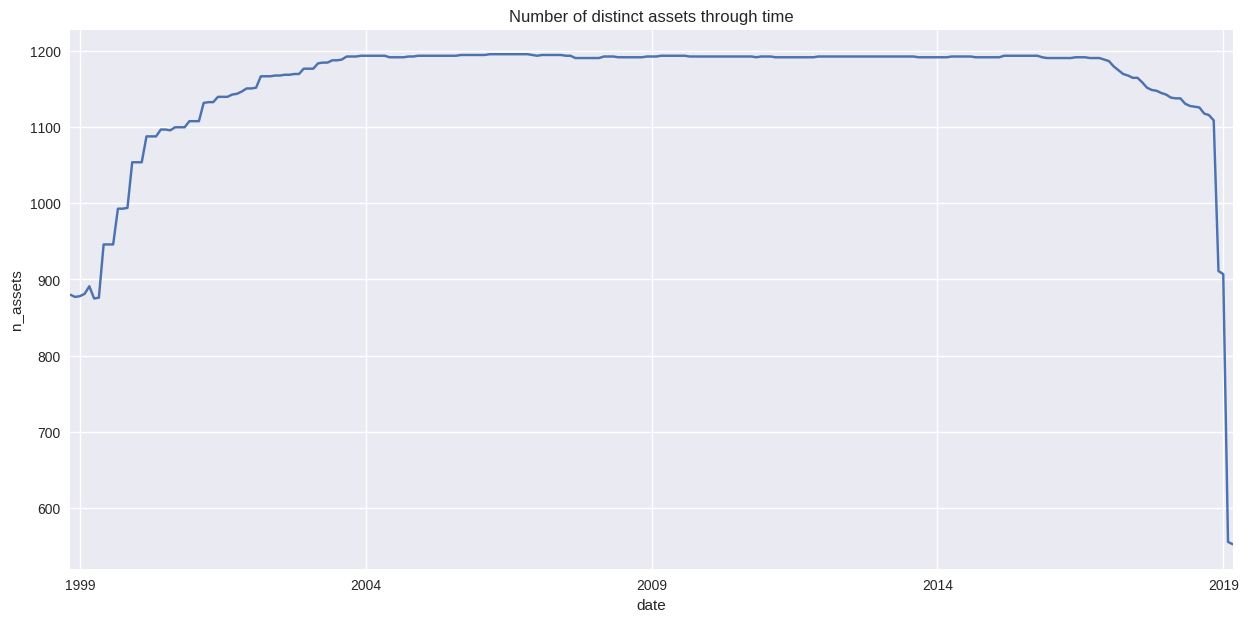

In [5]:
data.groupby('date')['stock_id'].count().plot(ylabel='n_assets',title='Number of distinct assets through time');

#### **2-3.** 독립변수(feature) 설정
feature_short는 간소화된 변수를 나타냅니다.

In [6]:
features = data.columns.to_list()[2:-4]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

##### **2-3-1.** 분류 task를 위한 종속변수(label) 데이터 추가 가공

분류 작업을 위해서 주식 수익률의 상승/하락을 이진으로 분류합니다.

In [7]:
data['R1M_Usd_C'] = data.groupby('date')['R1M_Usd'].apply(lambda x: (x > x.median()))
data['R12M_Usd_C'] = data.groupby('date')['R12M_Usd'].apply(lambda x: (x > x.median()))
# this creates dummy variables indicated whether the return of a given stock was higher
# than the median cross-section return. this will be used as the Y variable in
# categorical prediction problems afterwards. i.e. we'll try predict which stocks will perform relatively better

<ipython-input-7-bdf28320cb22>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['R1M_Usd_C'] = data.groupby('date')['R1M_Usd'].apply(lambda x: (x > x.median()))
<ipython-input-7-bdf28320cb22>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['R12M_Usd_C'] = data.groupby('date')['R12M_Us

#### **2-4.** 주식의 return table 생성

##### 2-4-1. train test dataset 생성

In [8]:
separation_date = '2014-1-15'
separation_mask = (data['date'] < separation_date)

training_sample = data.loc[separation_mask]
testing_sample = data.loc[~separation_mask]

##### 2-4-2. 모든 datatime에 존재하는 stock id 추출

In [9]:
stock_ids = data['stock_id'].unique().tolist()

max_dates = data.groupby('stock_id')['date'].count().max()
stocks_with_max_dates = data.groupby('stock_id')['date'].count() == max_dates
stock_ids_short = stocks_with_max_dates.where(stocks_with_max_dates).dropna().index.tolist() # these are stocks who have data for all timestamps

returns = data[data['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns.pivot(index='date',columns='stock_id');

In [13]:
returns.head()

R1M_Usd                                                          \
stock_id      3      4      7      9      16     22     24     27     30     
date                                                                         
1998-11-30   0.016 -0.088  0.031  0.011 -0.058  0.081 -0.006  0.080  0.054   
1998-12-31  -0.028 -0.081  0.039 -0.022 -0.126 -0.040  0.025  0.219 -0.074   
1999-01-31   0.004  0.041 -0.022 -0.084 -0.036 -0.077 -0.129 -0.110  0.040   
1999-02-28  -0.060 -0.106 -0.008 -0.053  0.144  0.009 -0.122  0.054 -0.092   
1999-03-31   0.071  0.070  0.023  0.044  0.079  0.059  0.149  0.144 -0.049   

                   ...                                                   \
stock_id     31    ...   1181   1183   1185   1186   1192   1199   1201   
date               ...                                                    
1998-11-30  0.023  ... -0.095  0.182 -0.181  0.068  0.023  0.065  0.006   
1998-12-31 -0.054  ... -0.119  0.138  0.000 -0.128 -0.025 -0.026 -0.124   
1999-01-31 -0.086  ...  0.158  0.111 -0.090 -0.213 -0.043 -0.176 -0.059   
1999-02-28  0.013  ...  0.242 -0.063  0.077 -0.068 -0.170 -0.064  0.003   
1999-03-31  0.116  ...  0.137 -0.075  0.095  0.277 -0.017  0.200  0.031   

                                 
stock_id     1202   1203   1210  
date                             
1998-11-30 -0.014 -0.242  0.038  
1998-12-31  0.065  0.030 -0.050  
1999-01-31  0.033 -0.289  0.022  
1999-02-28  0.039  0.635 -0.041  
1999-03-31  0.016 -0.052  0.069  

[5 rows x 372 columns]

In [29]:
returns.T

date              1998-11-30  1998-12-31  1999-01-31  1999-02-28  1999-03-31  \
        stock_id                                                               
R1M_Usd 3              0.016      -0.028       0.004      -0.060       0.071   
        4             -0.088      -0.081       0.041      -0.106       0.070   
        7              0.031       0.039      -0.022      -0.008       0.023   
        9              0.011      -0.022      -0.084      -0.053       0.044   
        16            -0.058      -0.126      -0.036       0.144       0.079   
...                      ...         ...         ...         ...         ...   
        1199           0.065      -0.026      -0.176      -0.064       0.200   
        1201           0.006      -0.124      -0.059       0.003       0.031   
        1202          -0.014       0.065       0.033       0.039       0.016   
        1203          -0.242       0.030      -0.289       0.635      -0.052   
        1210           0.038      -0.050       0.022      -0.041       0.069   

date              1999-04-30  1999-05-31  1999-06-30  1999-07-31  1999-08-31  \
        stock_id                                                               
R1M_Usd 3             -0.017       0.048       0.049       0.031      -0.029   
        4              0.064       0.005       0.106      -0.052      -0.017   
        7              0.000      -0.044      -0.008       0.008      -0.008   
        9             -0.064       0.004       0.045      -0.045      -0.013   
        16             0.064      -0.072      -0.109       0.012      -0.043   
...                      ...         ...         ...         ...         ...   
        1199          -0.073       0.303       0.052      -0.152      -0.088   
        1201           0.094       0.009      -0.037       0.038      -0.087   
        1202           0.004       0.054      -0.023      -0.059       0.033   
        1203           0.078       0.051       0.130       0.032      -0.186   
        1210           0.064      -0.010       0.000      -0.077       0.168   

date              ...  2018-06-30  2018-07-31  2018-08-31  2018-09-30  \
        stock_id  ...                                                   
R1M_Usd 3         ...      -0.039       0.033      -0.049      -0.070   
        4         ...       0.029      -0.004       0.036      -0.025   
        7         ...      -0.005       0.022      -0.068      -0.052   
        9         ...       0.064      -0.137      -0.028      -0.098   
        16        ...       0.024      -0.033       0.016      -0.050   
...               ...         ...         ...         ...         ...   
        1199      ...      -0.043       0.086      -0.006      -0.064   
        1201      ...      -0.044       0.058      -0.048      -0.070   
        1202      ...      -0.005       0.062      -0.010      -0.024   
        1203      ...      -0.049       0.045       0.037      -0.030   
        1210      ...      -0.006       0.021      -0.011       0.028   

date              2018-10-31  2018-11-30  2018-12-31  2019-01-31  2019-02-28  \
        stock_id                                                               
R1M_Usd 3              0.036      -0.070       0.030       0.046      -0.046   
        4              0.000      -0.088       0.043       0.050       0.022   
        7              0.007      -0.066       0.131       0.021      -0.013   
        9             -0.018      -0.099       0.112       0.022      -0.108   
        16             0.094      -0.059       0.039       0.015       0.003   
...                      ...         ...         ...         ...         ...   
        1199          -0.075      -0.066      -0.005       0.053      -0.019   
        1201           0.051      -0.197       0.184       0.043      -0.125   
        1202           0.078      -0.149       0.095      -0.017      -0.035   
        1203          -0.005      -0.079       0.061       0.176       0.014   
        

### **3.** Factor investing and asset pricing
파마-프렌치 5 팩터 모델을 사용한 회귀분석


#### 3-1. size factor에 따른 주식 수익률

<ipython-input-14-16f67722c69e>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data['size'] = data.groupby('date')['Mkt_Cap_12M_Usd'].apply(lambda x: (x > x.median())).replace({True:'Large',False:'Small'})


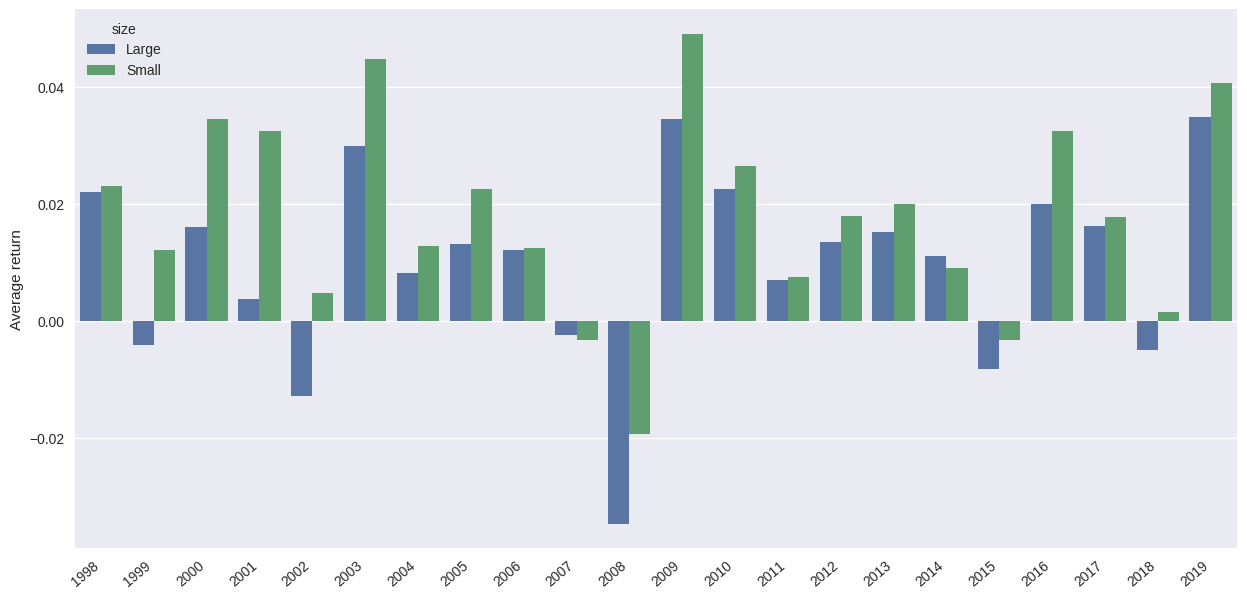

In [14]:
data['size'] = data.groupby('date')['Mkt_Cap_12M_Usd'].apply(lambda x: (x > x.median())).replace({True:'Large',False:'Small'})
data['year'] = data['date'].dt.year

return_by_size = data.groupby(['year','size'])['R1M_Usd'].mean().reset_index()

ax = sns.barplot(x='year',y='R1M_Usd',hue='size',data=return_by_size)
ax.set(xlabel = '', ylabel = 'Average return');
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

#### 3-2. 파마-프렌치 5팩터 모델

In [15]:
# below we download the factor data made available by ken french (yeah, fama's buddy)
# his website is a goldmine of factor-related data, it's highly advisable to do some digging
ff_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

ff_factors = pd.read_csv(ff_url, compression='zip', skiprows=3)
ff_factors.rename({'Unnamed: 0':'date','Mkt-RF':'MKT_RF'}, axis = 1, inplace=True)
ff_factors = ff_factors.loc[ff_factors['date'].str.strip(' ').str.len() == 6]

def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])

ff_factors['date'] = pd.to_datetime(ff_factors['date'], format = '%Y%m').apply(last_day_of_month)
ff_factors[ff_factors.columns[1:]] = ff_factors[ff_factors.columns[1:]].apply(pd.to_numeric) / 100

ff_factors.tail()

,date,MKT_RF,SMB,HML,RMW,CMA,RF
716,2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.0036
717,2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0035
718,2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,0.0036
719,2023-06-30,0.0646,0.0134,-0.0026,0.0218,-0.0162,0.0040
720,2023-07-31,0.0321,0.0286,0.0413,-0.0056,0.0062,0.0045


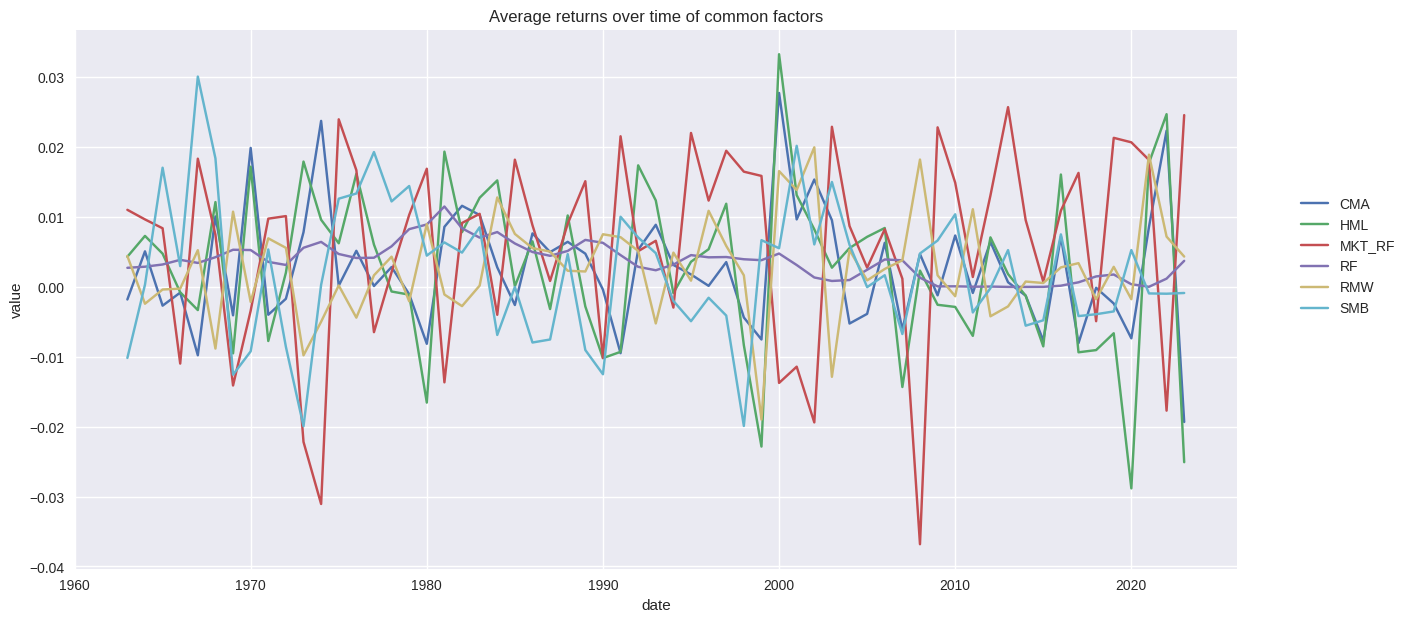

In [16]:
temp_factors = ff_factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()

plt = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors);
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.);
plt.set_title('Average returns over time of common factors');
# replicating this from the book for completeness only, but i think it's a pretty messy chart
# it's hard to take much insight from it

#### 3-3. 파마-멕베스 회귀

시계열의 횡단면과 종단면을 동시에 고려하는 회귀 방법

##### beta regression

In [19]:
# merging and cleaning up the data before we run the regressions
data_fm = data[['date','stock_id','R1M_Usd']][data['stock_id'].isin(stock_ids_short)]
data_fm = data_fm.merge(ff_factors, on = 'date')
data_fm['R1M_Usd'] = data_fm.groupby('stock_id')['R1M_Usd'].shift(1)
data_fm.dropna(inplace=True)

파마-벡메스 회귀를 위해서 주식 수익률, 날짜와 5가지 팩터를 합친 데이터프레임을 생성합니다.

In [21]:
data_fm.head()

,date,stock_id,R1M_Usd,MKT_RF,SMB,HML,RMW,CMA,RF
372,2001-01-31,44,5.000,0.0313,0.0548,-0.0507,-0.0469,-0.0503,0.0054
373,2001-01-31,597,0.033,0.0313,0.0548,-0.0507,-0.0469,-0.0503,0.0054
374,2001-01-31,296,0.770,0.0313,0.0548,-0.0507,-0.0469,-0.0503,0.0054
375,2001-01-31,486,0.136,0.0313,0.0548,-0.0507,-0.0469,-0.0503,0.0054
376,2001-01-31,558,0.033,0.0313,0.0548,-0.0507,-0.0469,-0.0503,0.0054


stock_id(횡단면)를 기준으로 모든 date에서 회귀분석을 진행합니다.

In [25]:
# running time series regressions
reg_output = {}

for k,g in data_fm.groupby('stock_id'):
  model = ols('R1M_Usd ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output[k] = results.params

betas = pd.DataFrame.from_dict(reg_output).T
betas.head()

,Intercept,MKT_RF,SMB,HML,RMW,CMA
3,-0.002193,0.856555,0.864555,0.737517,0.334009,-0.282986
4,0.003300,0.296396,0.338474,-0.148201,0.655343,0.422797
7,0.006110,0.370519,0.649548,0.221608,0.260229,0.177670
9,0.003118,0.841591,0.611987,1.030835,0.144572,0.134616
16,0.000433,1.177064,-0.129665,1.347758,0.120328,-0.335390


##### gamma regression

In [31]:
# prepping coeficient data to run second round of regressions
loadings = betas.drop('Intercept', axis = 1).reset_index(drop=True)
ret = returns.T.reset_index(drop=True)
fm_data = pd.concat([loadings,ret], axis=1)
fm_data = pd.melt(fm_data,id_vars=['MKT_RF','SMB','HML','RMW','CMA'])

In [28]:
fm_data.head()

,MKT_RF,SMB,HML,RMW,CMA,variable,value
0,0.856555,0.864555,0.737517,0.334009,-0.282986,1998-11-30,0.016
1,0.296396,0.338474,-0.148201,0.655343,0.422797,1998-11-30,-0.088
2,0.370519,0.649548,0.221608,0.260229,0.177670,1998-11-30,0.031
3,0.841591,0.611987,1.030835,0.144572,0.134616,1998-11-30,0.011
4,1.177064,-0.129665,1.347758,0.120328,-0.335390,1998-11-30,-0.058


In [32]:
# running cross section regressions

reg_output_2 = {}

for k,g in fm_data.groupby('variable'):
  model = ols('value ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output_2[k] = results.params

# refer to the mlfactor book or the fama-macbeth literature for more info on what the gammas stand for
# but you can think of them as an estimate of a given factor's risk premium at a point in time
gammas = pd.DataFrame.from_dict(reg_output_2).T.reset_index().rename({'index':'date'}, axis = 1)
gammas.head()

,date,Intercept,MKT_RF,SMB,HML,RMW,CMA
0,1998-11-30,0.024554,0.080675,-0.036210,-0.045368,-0.026312,-0.043774
1,1998-12-31,0.013531,0.022111,0.000908,-0.039176,-0.059628,-0.057862
2,1999-01-31,-0.026975,-0.044047,-0.013928,0.034602,0.010632,0.033497
3,1999-02-28,-0.033445,0.047039,-0.022606,0.005010,-0.023466,-0.013590
4,1999-03-31,-0.000012,0.097083,0.004241,0.004732,-0.029064,-0.015922


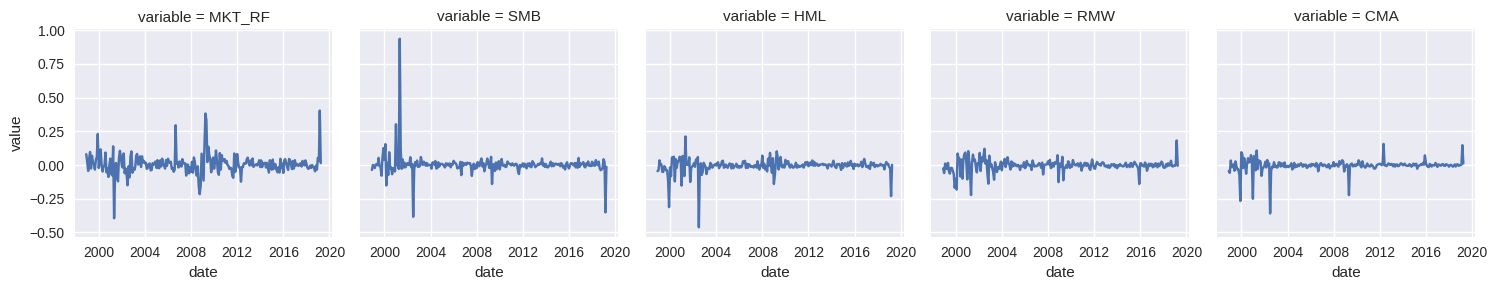

In [ ]:
# since we get one estimate of that risk premium for each time step, we can plot how it evolves over time
x = pd.melt(gammas.drop('Intercept',axis=1), id_vars='date')

g = sns.FacetGrid(x, col='variable');
g.map(sns.lineplot, 'date', 'value');

##### factor competition
factor competition에서 주요 아이디어는 한 요인을 나머지 factor에 회귀시키고 그 계수가 유의한지 테스트하는 것입니다. 계수가 유의하다는 것은 right-term의 factor가 left-term의 factor을 완전히 설명하지 못한다는 것을 의미하며, 이는 당연히 후자의 factor가 유용하다는 것을 의미합니다.

In [ ]:
factor_comp = pd.melt(ff_factors.drop('RF',axis=1),id_vars='date')

factor_comp = factor_comp.merge(ff_factors.drop('RF',axis=1), on = 'date')

factor_comp_coefs = {}
factor_comp_tstats = {}

for k,g in factor_comp.groupby('variable'):

  reg_data = g.drop([k,'date','variable'],axis=1)
  formula = 'value ~ ' + ' + '.join(reg_data.columns.values[1:].tolist())

  model = ols(formula, data=reg_data)
  results = model.fit()

  factor_comp_coefs[k] = results.params
  factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,CMA,HML,Intercept,MKT_RF,RMW,SMB
CMA,NaN,24.913173,4.766175,-8.597219,-4.878821,-2.438504
HML,24.913173,NaN,-1.140592,1.720466,4.737333,2.974103
MKT_RF,-8.597219,1.720466,5.082860,NaN,-3.328437,5.534614
RMW,-4.878821,4.737333,5.116786,-3.328437,NaN,-9.375519
SMB,-2.438504,2.974103,2.597470,5.534614,-9.375519,NaN


In [ ]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + ' (**)'
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + ' (*)'

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[['Intercept'] + factors].reindex(factors)

alphas_table

,Intercept,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.008 (**),nan,0.296 (**),0.12,-0.243,-0.866
SMB,0.003 (**),0.139 (**),nan,0.141 (**),-0.445,-0.176
HML,-0.001,0.034,0.086 (**),nan,0.184 (**),1.031 (**)
RMW,0.004 (**),-0.063,-0.246,0.166 (**),nan,-0.258
CMA,0.003 (**),-0.108,-0.047,0.45 (**),-0.125,nan


### **4.** Data visualize

##### 주요 피처들과 한달간 누적수익률 간의 관계

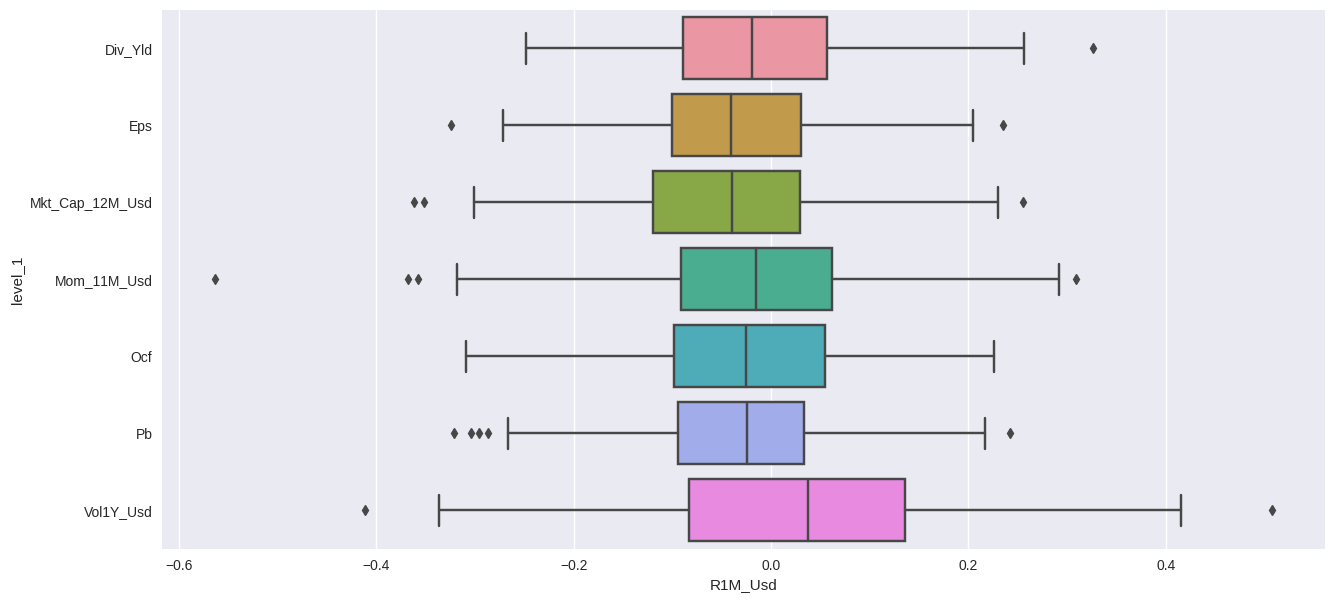

In [37]:
cols_to_keep = features_short+['R1M_Usd','date']
corr_data = data[cols_to_keep]
corr_data = corr_data.groupby('date').corr()[['R1M_Usd']].reset_index()
corr_data = corr_data.loc[corr_data['level_1']!='R1M_Usd']

sns.boxplot(x='R1M_Usd',y='level_1', data = corr_data);

#####

##### 1달 수익률에 따른 1년 수익률과 1년 변동성

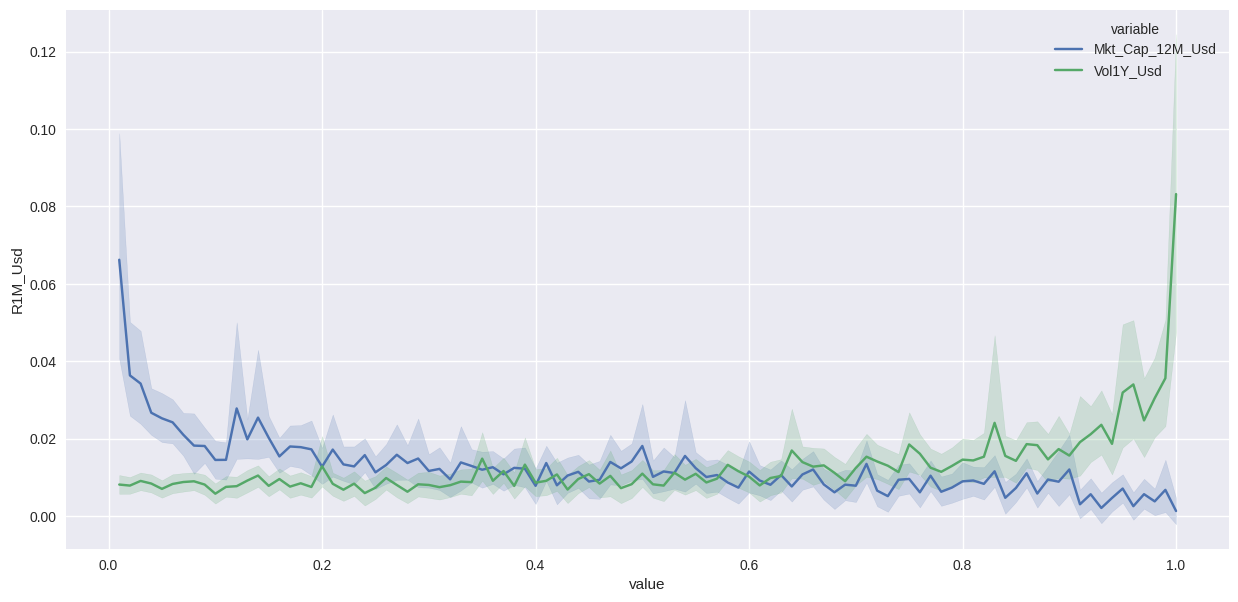

In [38]:
x = pd.melt(data[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd')

sns.lineplot(data = x, y='R1M_Usd', x='value', hue='variable');

### **5.** Penalized regressions

regularization을 적용한 회귀 방법

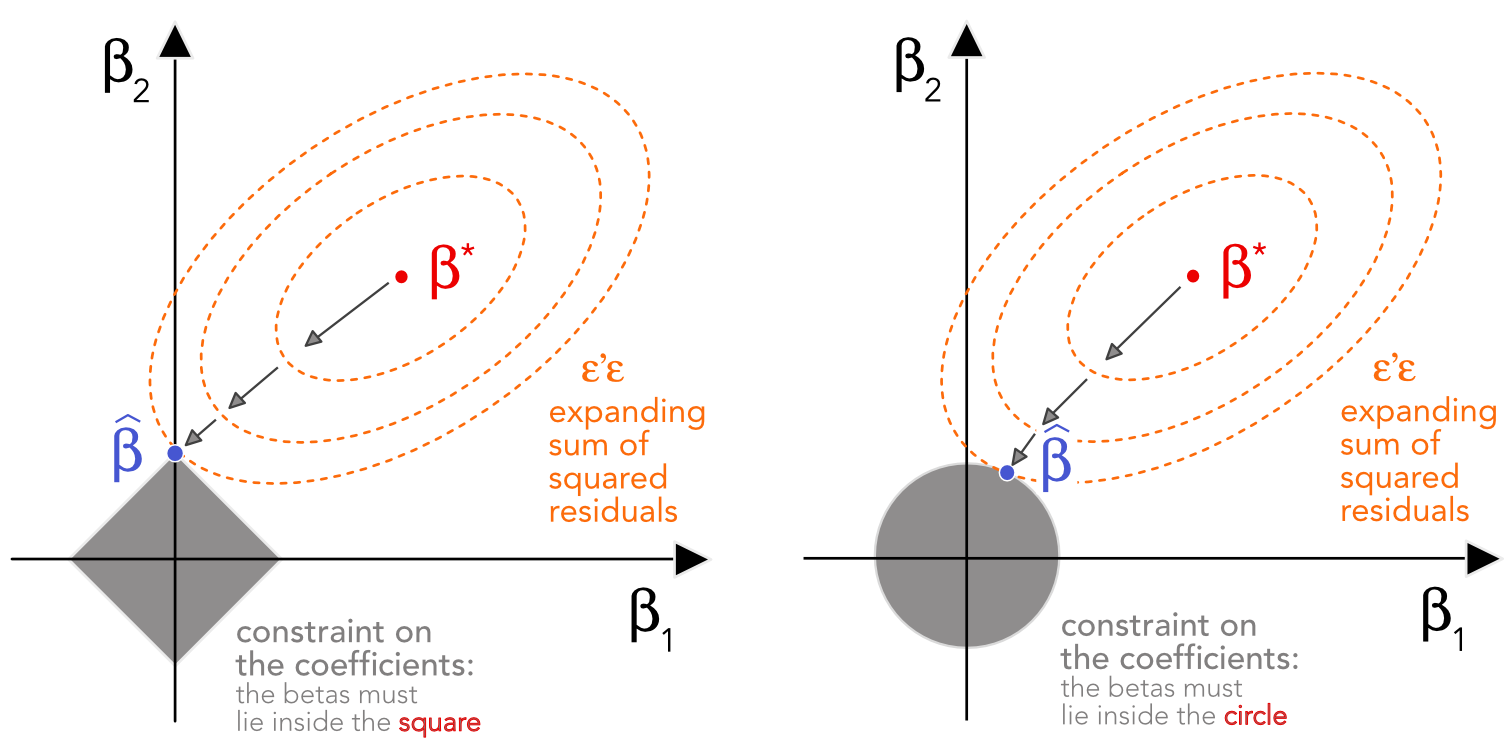

##### lasso regression

In [ ]:
y_penalized = data['R1M_Usd'].values
X_penalized = data[features].values

alphas = np.arange(1e-3,2.5e-3,1e-4) # sklearn alpha = glmnet lambda

coef_path = {}

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_penalized,y_penalized)

  coef_path[alpha] = lasso.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)

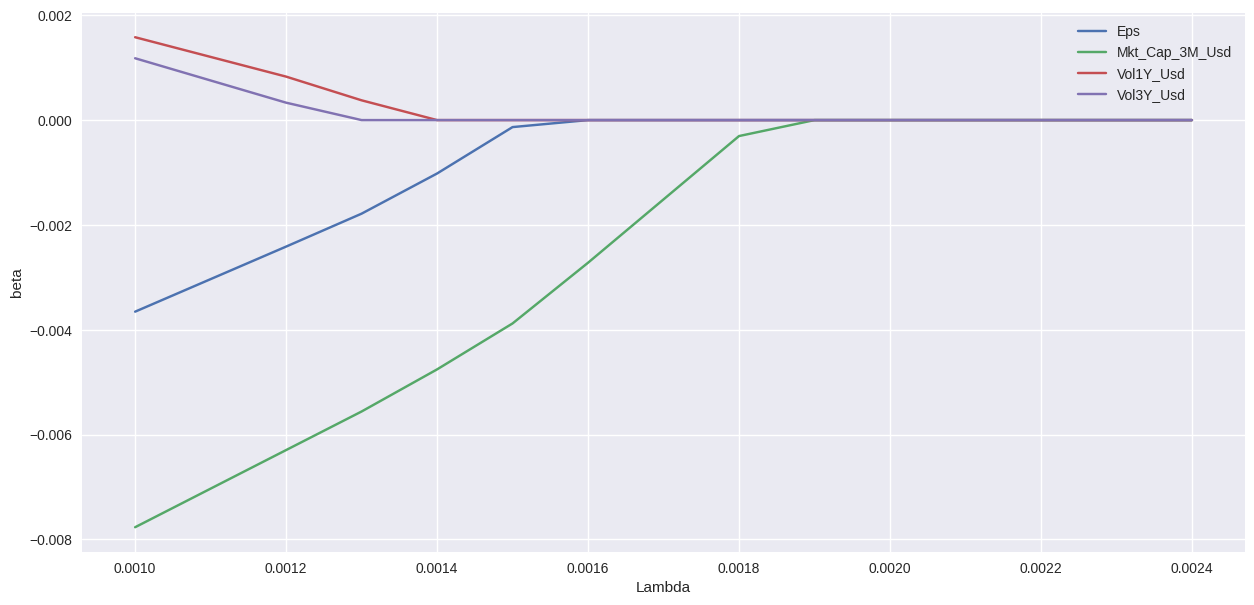

In [ ]:
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta');

In [161]:
y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values

model = Lasso(alpha=0.001)
model.fit(X_penalized_train,y_penalized_train)

y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values

mse = np.mean((model.predict(X_penalized_test) - y_penalized_test)**2)
hitratio = np.mean(model.predict(X_penalized_test) * y_penalized_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03948076140643327 
Hit Ratio: 0.5494447675223616


In [162]:
joblib.dump(model, '/content/drive/MyDrive/UFEA_model/lasso_model.pkl')

['/content/drive/MyDrive/UFEA_model/lasso_model.pkl']

##### ridge regression

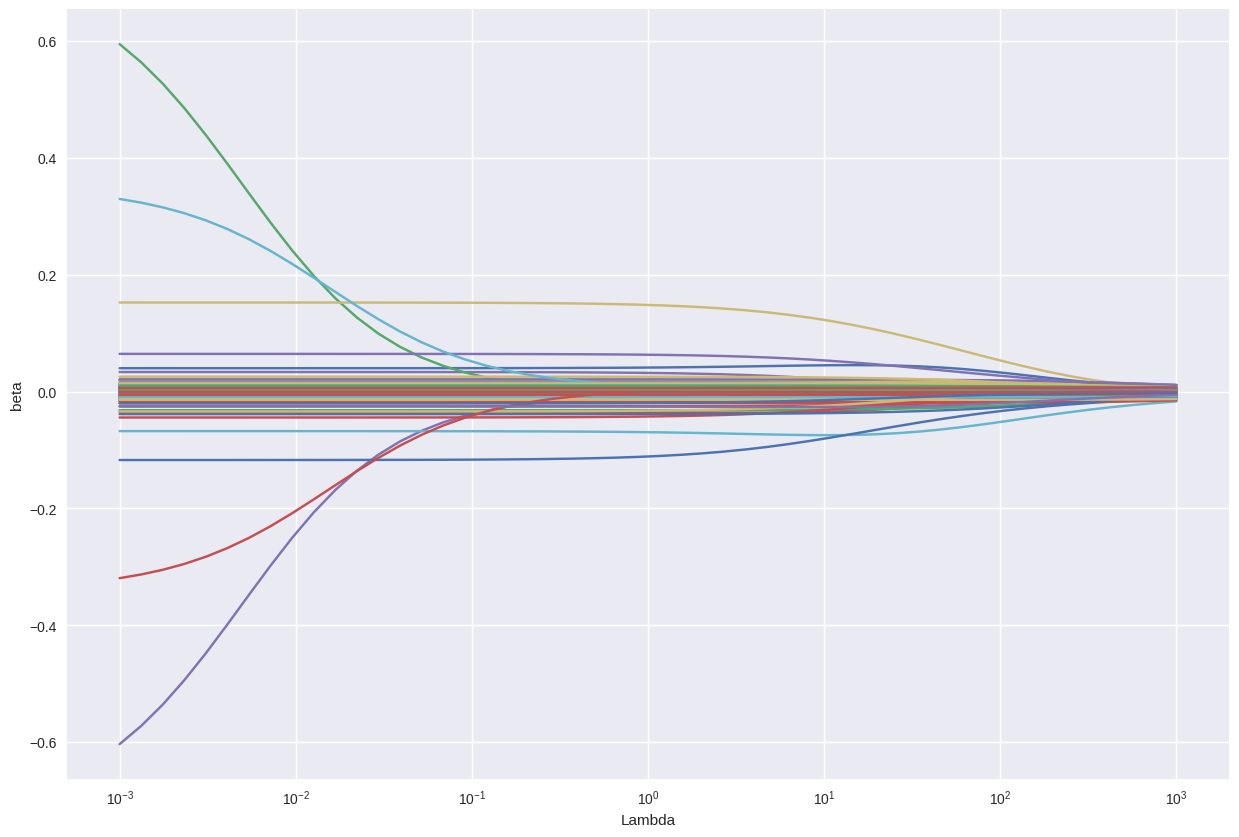

In [ ]:
alphas = np.logspace(-3,3,50)

coef_path = {}

for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_penalized,y_penalized)

  coef_path[alpha] = ridge.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta',figsize=(15,10),legend=False, logx=True);

In [42]:
y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values

model = Ridge(alpha=0.01)
model.fit(X_penalized_train,y_penalized_train)

y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values

mse = np.mean((model.predict(X_penalized_test) - y_penalized_test)**2)
hitratio = np.mean(model.predict(X_penalized_test) * y_penalized_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03955900045818606 
Hit Ratio: 0.528398548918612


##### elastic regression

In [159]:
y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values

elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.001)
elastic_model.fit(X_penalized_train,y_penalized_train)

y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values

mse = np.mean((elastic_model.predict(X_penalized_test) - y_penalized_test)**2)
hitratio = np.mean(elastic_model.predict(X_penalized_test) * y_penalized_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03952713355354585 
Hit Ratio: 0.5305724017612362


### **6.** Tree-based methods

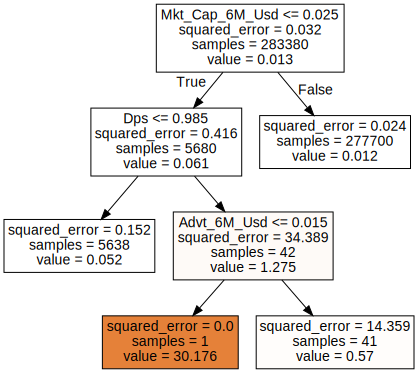

In [44]:
y = data['R1M_Usd'].values
X = data[features].values

clf = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
clf = clf.fit(X,y)

dot_data = tree.export_graphviz(clf,out_file=None,
                                feature_names=features,
                                filled = True)

graph = graphviz.Source(dot_data)
graph

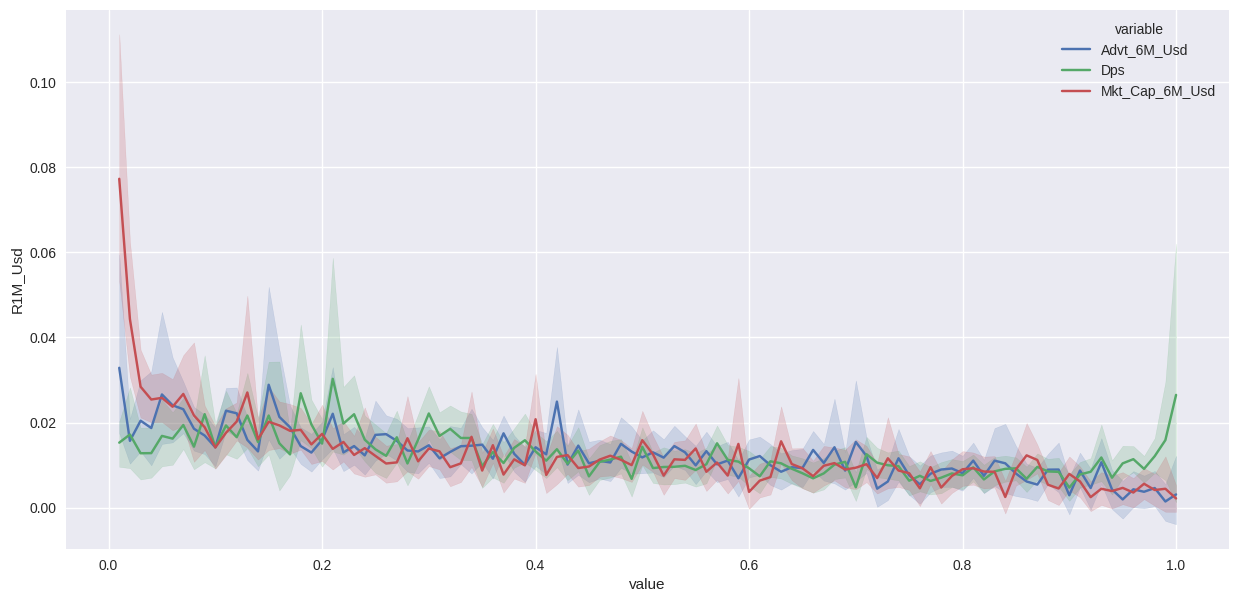

In [ ]:
cols_that_matter = []

for val in np.where(clf.feature_importances_ > 0)[0]:
  cols_that_matter.append(features[val])


temp = pd.melt(data[['R1M_Usd']+cols_that_matter], id_vars='R1M_Usd')

sns.lineplot(data = temp, y='R1M_Usd', x='value', hue='variable');

##### Decision Tree

In [ ]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

dt = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
dt.fit(X_train,y_train)

y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

mse = np.mean((dt.predict(X_test) - y_test)**2)
hitratio = np.mean(dt.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03949451472449276 
Hit Ratio: 0.5494447675223616


##### RF

In [ ]:
rf = RandomForestRegressor(n_estimators=40,
                           max_features = 30,
                           min_samples_split=10000,
                           bootstrap=False)
rf.fit(X_train,y_train)

mse = np.mean((rf.predict(X_test) - y_test)**2)
hitratio = np.mean(rf.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.039438310785507386 
Hit Ratio: 0.5467309130181939


##### XGBOOST

In [214]:
import xgboost
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0,
                           colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [215]:
mse = np.mean((xgb_model.predict(X_test) - y_test)**2)
hitratio = np.mean(xgb_model.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.04114247134489073 
Hit Ratio: 0.5490847664146659


In [216]:
joblib.dump(xgb_model, '/content/drive/MyDrive/UFEA_model/xgb_model.pkl')

['/content/drive/MyDrive/UFEA_model/xgb_model.pkl']

### **7.** Neural networks

##### Dense Layer model

In [45]:
NN_train_features = training_sample[features].values
NN_train_labels = training_sample['R1M_Usd'].values

NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['R1M_Usd'].values

In [103]:
model = keras.Sequential(
    [
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(1)
    ]
)

loss_fn = keras.losses.MeanSquaredError() #regression yay

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(optimizer,loss=loss_fn,metrics=['MeanSquaredError'])

epochs = 100

fitted_model = model.fit(
            NN_train_features,
            NN_train_labels,
            batch_size=256,
            epochs = epochs,
            validation_data=(NN_test_features,NN_test_labels),
            callbacks = [keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    min_delta=0.001,
                    patience= epochs/10,
                    verbose=False)]
)

Epoch 1/100
825/825 [==============================] - 5s 5ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0432 - val_mean_squared_error: 0.0432
Epoch 2/100
825/825 [==============================] - 5s 6ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 3/100
825/825 [==============================] - 4s 4ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 4/100
825/825 [==============================] - 4s 4ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 5/100
825/825 [==============================] - 4s 5ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 6/100
825/825 [==============================] - 5s 6ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 7/100
825/825 [=

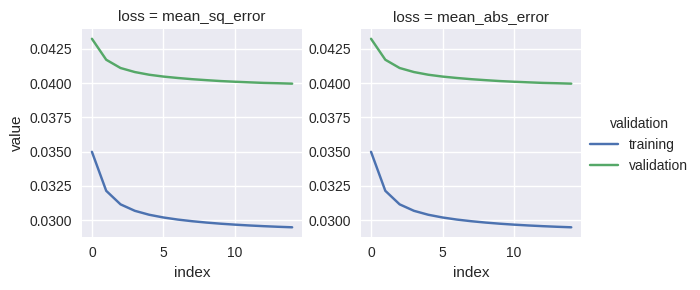

In [104]:
def plot_model_performance(mdl, loss, metric):
  x = pd.DataFrame(mdl.history).reset_index()
  x = pd.melt(x, id_vars='index')

  x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
  x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})

  g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
  g.map(sns.lineplot, 'index','value')
  g.add_legend()

  return g

plot_model_performance(fitted_model,'mean_sq_error','mean_abs_error');

In [105]:
NN_preds = model.predict(NN_test_features, use_multiprocessing=True)
NN_preds = NN_preds.reshape(NN_preds.shape[0])

hitratio = np.mean(np.multiply(NN_preds,NN_test_labels) > 0)
print(f'Hit Ratio: {hitratio}')

2257/2257 [==============================] - 4s 2ms/step
Hit Ratio: 0.5228046855528786


In [117]:
model.save('/content/drive/MyDrive/UFEA_model/nn_model.h5')

##### RNN model

In [46]:
data_rnn = data[data['stock_id'].isin(stock_ids_short)]
training_sample_rnn = data_rnn[data_rnn['date'] < separation_date]
testing_sample_rnn = data_rnn[data_rnn['date'] > separation_date]

nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = training_sample_rnn.shape[0] // nb_stocks
nb_dates_test = testing_sample_rnn.shape[0] // nb_stocks

In [47]:
nn_train_features = training_sample_rnn[features].values
train_features_rnn = np.reshape(nn_train_features, (nb_stocks, nb_dates_train, nb_feats))

nn_test_features = testing_sample_rnn[features].values
test_features_rnn = np.reshape(nn_test_features, (nb_stocks, nb_dates_test, nb_feats))

nn_train_labels = training_sample_rnn['R1M_Usd'].values
train_labels_rnn = np.reshape(nn_train_labels, (nb_stocks, nb_dates_train, 1))

nn_test_labels = testing_sample_rnn['R1M_Usd'].values
test_labels_rnn = np.reshape(nn_test_labels, (nb_stocks, nb_dates_test, 1))

In [56]:
train_features_rnn.shape, train_labels_rnn.shape

((372, 182, 93), (372, 182, 1))

In [110]:
model_rnn = keras.Sequential(
    [
        keras.layers.GRU(64, batch_input_shape = (nb_stocks, nb_dates_train, nb_feats), activation='tanh', return_sequences=True),
        keras.layers.Dense(32),
        keras.layers.Dense(8),
        keras.layers.Dense(1)
    ]
)

optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.MeanSquaredError()

model_rnn.compile(loss = loss_fn, optimizer = optimizer, metrics=['MeanAbsoluteError'])

epochs = 120

fitted_model_rnn = model_rnn.fit(train_features_rnn,
                                train_labels_rnn,
                                batch_size=nb_stocks,
                                epochs = epochs,
                                verbose=0
)

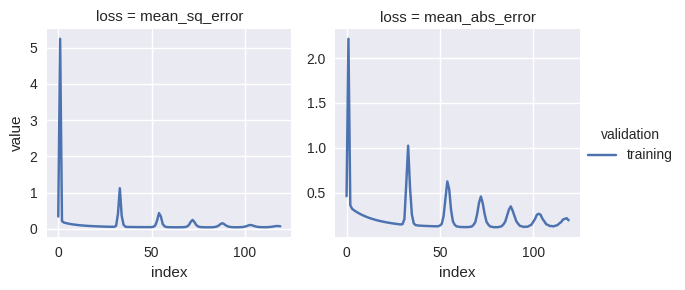

In [111]:
plot_model_performance(fitted_model_rnn,'mean_sq_error','mean_abs_error');

In [113]:
new_model_rnn = keras.Sequential(
    [
        keras.layers.GRU(64, batch_input_shape = (nb_stocks, nb_dates_test, nb_feats), activation='tanh', return_sequences=True),
        keras.layers.Dense(32),
        keras.layers.Dense(8),
        keras.layers.Dense(1)
    ]
)

new_model_rnn.set_weights(model_rnn.get_weights())

In [114]:
NN_preds = new_model_rnn.predict(test_features_rnn, batch_size = nb_stocks)

hitratio = np.mean(np.multiply(NN_preds,test_labels_rnn) > 0)
print(f'Hit Ratio: {hitratio}')

1/1 [==============================] - 0s 357ms/step
Hit Ratio: 0.5446321897934802


In [128]:
new_model_rnn.save('/content/drive/MyDrive/UFEA_model/rnn_model.h5')

## **8.**Ensemble
elelastic 회귀 모델, XGB 회귀 모델, 딥러닝 회귀모델의 predict를 input으로 받는 회귀 모델과 Tree기반 모델과 딥러닝 모델 생성.

In [217]:
import joblib

xgb_model = joblib.load('/content/drive/MyDrive/UFEA_model/xgb_model.pkl')

lasso_model = joblib.load('/content/drive/MyDrive/UFEA_model/lasso_model.pkl')

rf_model = joblib.load('/content/drive/MyDrive/UFEA_model/rf_model.pkl')

nn_model  = tf.keras.models.load_model('/content/drive/MyDrive/UFEA_model/nn_model.h5', compile=False)

rnn_model  = tf.keras.models.load_model('/content/drive/MyDrive/UFEA_model/rnn_model.h5', compile=False)

In [220]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

In [221]:
xgb_pred_train = xgb_model.predict(X_train).reshape(-1,1)
lasso_pred_train = lasso_model.predict(X_train).reshape(-1,1)
rf_pred_train = rf_model.predict(X_train).reshape(-1,1)

In [222]:
xgb_pred_test = xgb_model.predict(X_test).reshape(-1,1)
lasso_pred_test = lasso_model.predict(X_test).reshape(-1,1)
rf_pred_test = rf_model.predict(X_test).reshape(-1,1)

In [223]:
X_train_ensemble = np.concatenate([xgb_pred_train,lasso_pred_train,rf_pred_train], axis=1)
X_test_ensemble = np.concatenate([xgb_pred_test,lasso_pred_test,rf_pred_test], axis=1)

In [225]:
ensemble_model = xgboost.XGBRegressor(n_estimators=50, learning_rate=0.01, gamma=0,
                           colsample_bytree=1, max_depth=7)

ensemble_model.fit(X_train_ensemble, y_train)

mse = np.mean((ensemble_model.predict(X_test_ensemble) - y_test)**2)
hitratio = np.mean(ensemble_model.predict(X_test_ensemble) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.040305768586732606 
Hit Ratio: 0.5483509180028246


In [227]:
joblib.dump(ensemble_model, '/content/drive/MyDrive/UFEA_model/ensemble_model.pkl')

['/content/drive/MyDrive/UFEA_model/ensemble_model.pkl']

## **9.** Model explaination

In [268]:
lasso_model_feature = pd.DataFrame(abs(lasso_model.coef_), index=features, columns=["lasso_feature_importances"]).sort_values(by='lasso_feature_importances', ascending=False)
lasso_model_feature.head()

,lasso_feature_importances
Mkt_Cap_3M_Usd,0.009067
Vol3Y_Usd,0.004030
Eps,0.003746
Vol1Y_Usd,0.003230
Pb,0.002648


In [269]:
xgb_model_features = pd.DataFrame(abs(xgb_model.feature_importances_), index=features, columns=["xgb_feature_importances"]).sort_values(by='xgb_feature_importances', ascending=False)
xgb_model_features.head()

,xgb_feature_importances
Fa_Ci,0.097230
Share_Turn_12M,0.064882
Capex_Sales,0.060991
Mom_5M_Usd,0.048633
Noa,0.041626


In [270]:
rf_model_features = pd.DataFrame(abs(rf_model.feature_importances_), index=features, columns=["rf_feature_importances"]).sort_values(by='rf_feature_importances', ascending=False)
rf_model_features.head()

,rf_feature_importances
Mkt_Cap_3M_Usd,0.151224
Vol3Y_Usd,0.114708
Vol1Y_Usd,0.083249
Mkt_Cap_6M_Usd,0.072491
Pb,0.058959


In [238]:
ensemble_model_features = pd.DataFrame(abs(ensemble_model.feature_importances_), index=['xgb', 'lasso', 'rf'], columns=["ensemble_model_importances"]).sort_values(by='ensemble_model_importances', ascending=False)
ensemble_model_features

,ensemble_model_importances
xgb,0.571890
lasso,0.222671
rf,0.205440


In [272]:
feature_importances = pd.concat([lasso_model_feature, xgb_model_features, rf_model_features], axis=1)
feature_importances.head()

,lasso_feature_importances,xgb_feature_importances,rf_feature_importances
Mkt_Cap_3M_Usd,0.009067,0.005010,0.151224
Vol3Y_Usd,0.004030,0.004135,0.114708
Eps,0.003746,0.001997,0.012984
Vol1Y_Usd,0.003230,0.006672,0.083249
Pb,0.002648,0.005653,0.058959


In [271]:
feature_importances["sum"] = np.sum(feature_importances, axis=1)
feature_importances["weighted_sum"] = np.sum(pd.concat([lasso_model_feature* 0.222671,  xgb_model_features*0.571890,  rf_model_features*0.205440], axis=1),axis=1)
feature_importances.head(10)

,lasso_feature_importances,xgb_feature_importances,rf_feature_importances,sum,weighted_sum
Mkt_Cap_3M_Usd,0.009067,0.005010,0.151224,0.862454,0.035951
Vol3Y_Usd,0.004030,0.004135,0.114708,0.641199,0.026828
Eps,0.003746,0.001997,0.012984,0.098281,0.004644
Vol1Y_Usd,0.003230,0.006672,0.083249,0.487391,0.021637
Pb,0.002648,0.005653,0.058959,0.352235,0.015935
Ni,0.000000,0.008060,0.006518,0.078838,0.005948
Ni_Avail_Margin,0.000000,0.000878,0.001858,0.014561,0.000884
Op_Prt_Margin,0.000000,0.001080,0.001021,0.011333,0.000827
Op_Margin,0.000000,0.005095,0.002770,0.042810,0.003483
Ocf_Toa,0.000000,0.000708,0.001493,0.011719,0.000712


In [264]:
feature_importances['weighted_sum'].to_frame().sort_values(by='weighted_sum', ascending=False).head(10)

,weighted_sum
Fa_Ci,0.055792
Share_Turn_12M,0.037565
Mom_5M_Usd,0.036913
Mkt_Cap_3M_Usd,0.035951
Capex_Sales,0.035225
Vol3Y_Usd,0.026828
Noa,0.024248
Vol1Y_Usd,0.021637
Mom_11M_Usd,0.021022
Div_Yld,0.018760
